In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs1/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs1/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [4]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs1/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band08_wn_1380_1900',
                          'ng_7',
                          'g_ascending_k_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__1__3',
                          'getabsth_auto__auto__auto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_.55_.55_.85__.85__0_.3_.55',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'crd_a140ac7',
                          'atmpro_saw')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [5]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs1/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band08_wn_1380_1900',
                          'ng_7',
                          'g_ascending_k_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__1__3',
                          'getabsth_auto__auto__auto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_.55_.55_.85__.85__0_.3_.55',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'crd_a140ac7',
                          'atmpro_saw')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [6]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(range(1, 7 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [7]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [8]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [9]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [10]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1380

nband = 520

nv = 200

dv = 0.005

tsfc = 257.0

ng = 7

nref = 3

p_refs = (/ 1,  10, 500 /)

t_refs = (/ 250, 250, 250 /)

ng_refs = (/ 3,   1,   3 /)

data wgt
     &     /.55, .55, .85,
     &     .85,
     &     0, .3, .55/

option_wgt_flux = 2

option_wgt_k = 1

option_klin = 0

klin = 6.375563e-24

include 'saw75.pro'


In [11]:
fig.display_hrefanchor()

In [12]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [13]:
table_dgdgs.display_hrefanchor()

In [14]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [15]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [16]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

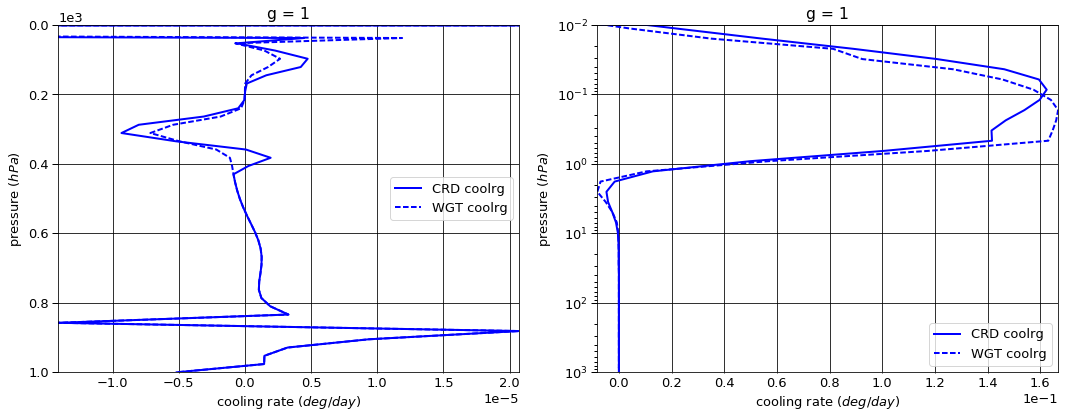

# Figure: cooling rate g-group 2

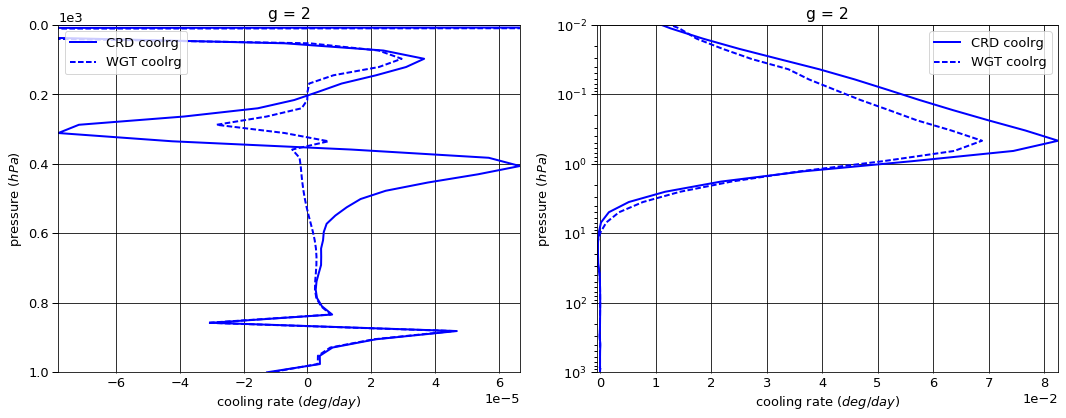

# Figure: cooling rate g-group 3

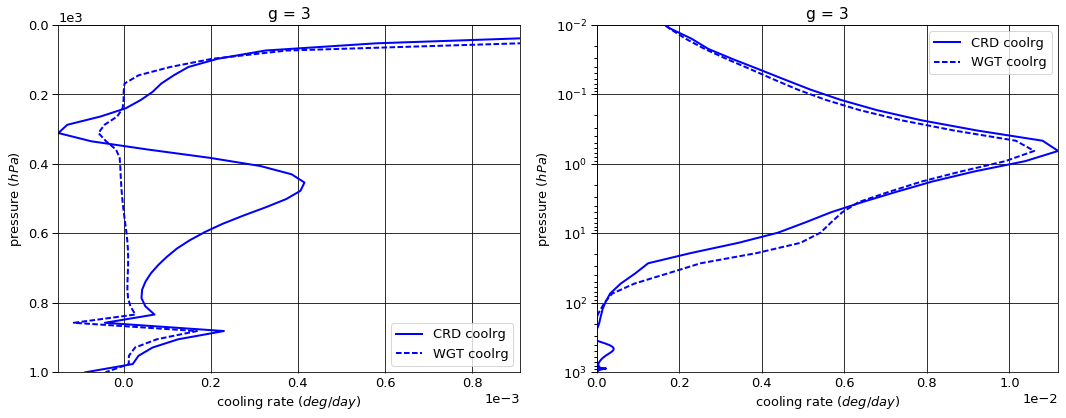

# Figure: cooling rate g-group 4

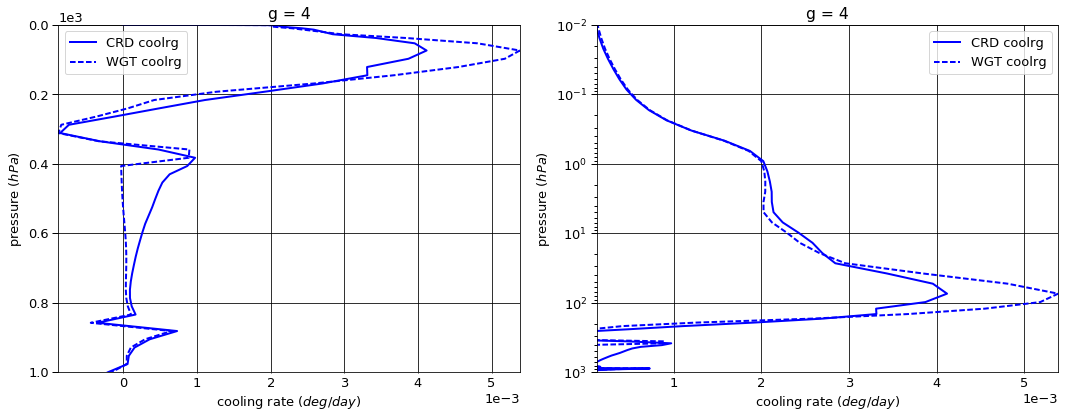

# Figure: cooling rate g-group 5

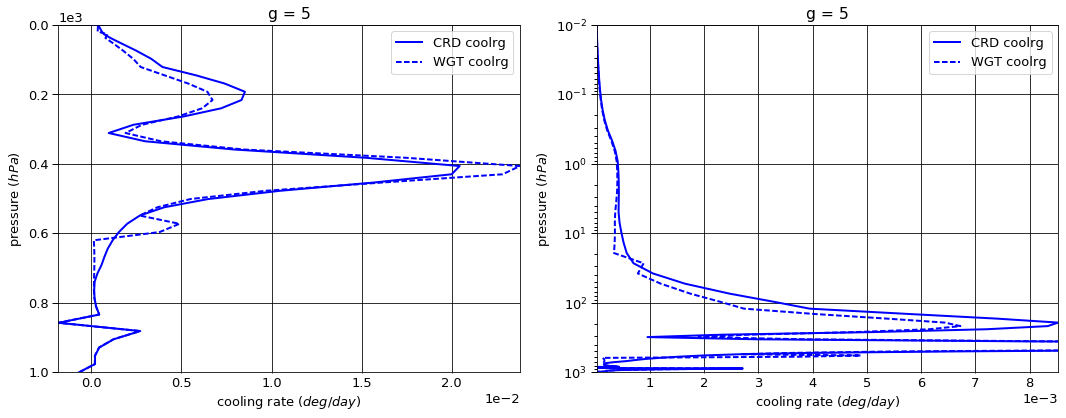

# Figure: cooling rate g-group 6

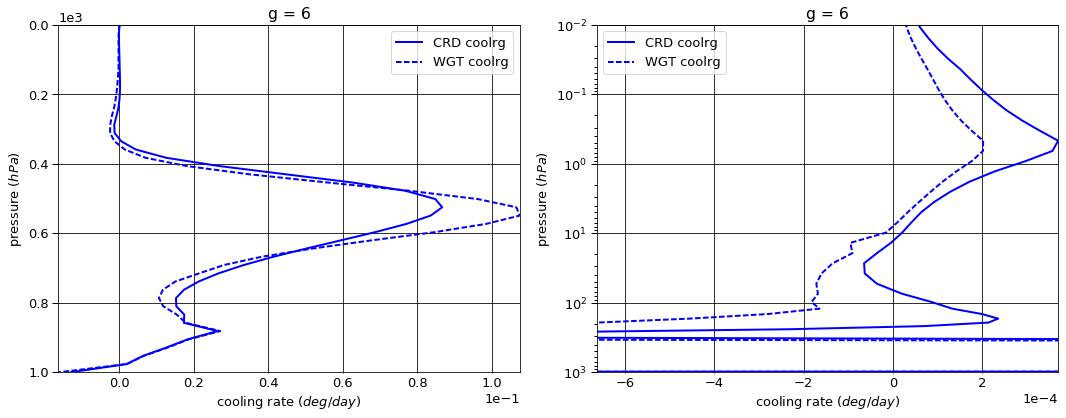

# Figure: cooling rate g-group 7

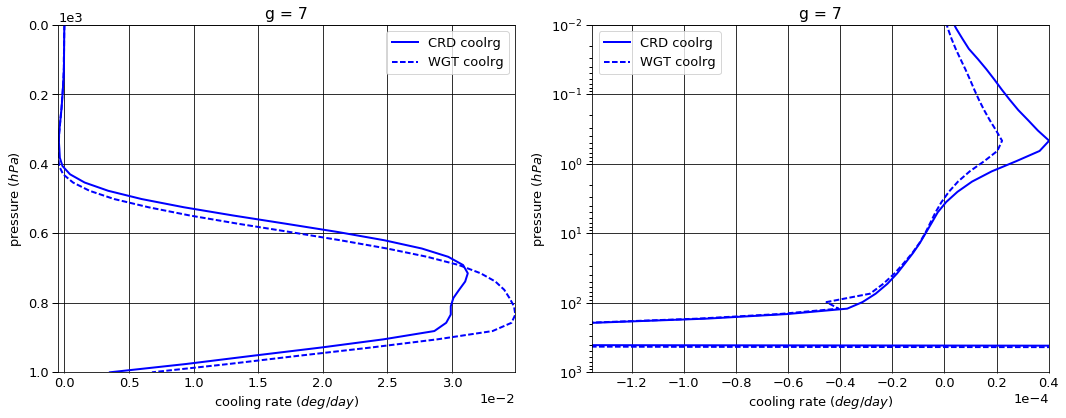

# Figure: cooling rate g-group total

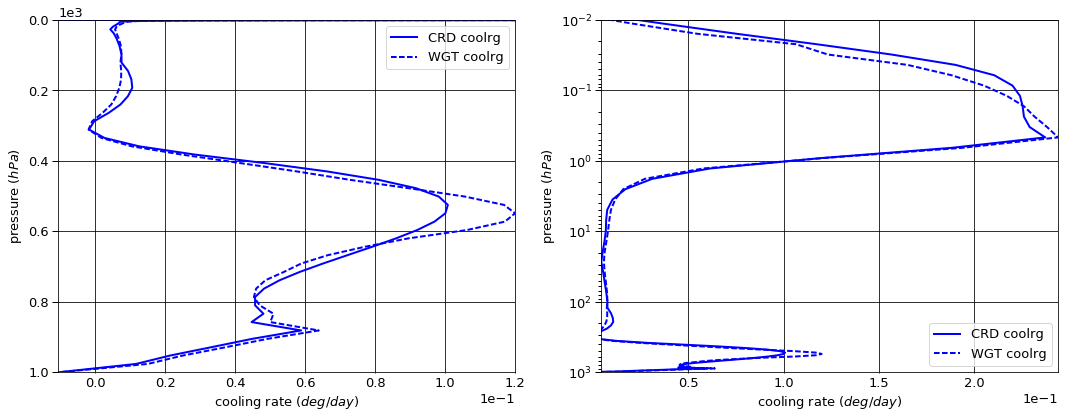

In [17]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [18]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.011810  0.000000 -0.011810
  1013.0   76    -0.015238  0.015256  0.000018
2 0.0      1     -0.013660  0.000000 -0.013660
  1013.0   76    -0.033942  0.033985  0.000044
3 0.0      1     -0.029025  0.000000 -0.029025
  1013.0   76    -0.123747  0.124111  0.000364
4 0.0      1     -0.097283  0.000000 -0.097283
  1013.0   76    -0.479588  0.480397  0.000809
5 0.0      1     -0.489346  0.000000 -0.489346
  1013.0   76    -1.991620  1.993977  0.002357
6 0.0      1     -2.739855  0.000000 -2.739855
  1013.0   76    -5.665124  5.730406  0.065282
7 0.0      1     -1.495939  0.000000 -1.495939
  1013.0   76    -1.872182  1.770251 -0.101931


WGT


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.012579  0.000000 -0.012579
  1013.0   76    -0.015238  0.015256  0.000018
2 0.0      1     -0.013005  0.000000 -0.013005
  1013.0   76    -0.033942  0.033981  0.000039
3 0.0      1     -0.023474  0.000000 -0.023474
  1013.0   76    -0.123747  0.123889  0.000142
4 0.0      1     -0.090564  0.000000 -0.090564
  1013.0   76    -0.479588  0.480139  0.000551
5 0.0      1     -0.487488  0.000000 -0.487488
  1013.0   76    -1.991620  1.993906  0.002286
6 0.0      1     -2.798298  0.000000 -2.798298
  1013.0   76    -5.665124  5.735078  0.069954
7 0.0      1     -1.547479  0.000000 -1.547479
  1013.0   76    -1.872182  1.780045 -0.092138


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000769  0.000000 -0.000769
  1013.0   76     0.000000  0.000000  0.000000
2 0.0      1      0.000655  0.000000  0.000655
  1013.0   76     0.000000 -0.000005 -0.000005
3 0.0      1      0.005551  0.000000  0.005551
  1013.0   76     0.000000 -0.000222 -0.000222
4 0.0      1      0.006719  0.000000  0.006719
  1013.0   76     0.000000 -0.000258 -0.000258
5 0.0      1      0.001857  0.000000  0.001857
  1013.0   76     0.000000 -0.000071 -0.000071
6 0.0      1     -0.058443  0.000000 -0.058443
  1013.0   76     0.000000  0.004672  0.004672
7 0.0      1     -0.051540  0.000000 -0.051540
  1013.0   76     0.000000  0.009794  0.009794

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.187947
  1001.112500 75    -0.000005
2 0.000312    1     -0.011383
  1001.112500 75    -0.000013
3 0.000312    1      0.000040
  1001.112500 75    -0.000088
4 0.000312    1     -0.000003
  1001.112500 75    -0.000212
5 0.000312    1      0.000002
  1001.112500 75    -0.000691
6 0.000312    1     -0.000013
  1001.112500 75    -0.013048
7 0.000312    1     -0.000006
  1001.112500 75     0.003522


WGT


coolrg
g pressure    layer          
1 0.000312    1     -0.162782
  1001.112500 75    -0.000005
2 0.000312    1     -0.004423
  1001.112500 75    -0.000011
3 0.000312    1      0.000175
  1001.112500 75    -0.000042
4 0.000312    1      0.000017
  1001.112500 75    -0.000162
5 0.000312    1      0.000001
  1001.112500 75    -0.000672
6 0.000312    1     -0.000008
  1001.112500 75    -0.016331
7 0.000312    1     -0.000005
  1001.112500 75     0.006777


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.516491e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      6.959530e-03
  1001.112500 75     1.250310e-06
3 0.000312    1      1.357717e-04
  1001.112500 75     4.618501e-05
4 0.000312    1      2.042703e-05
  1001.112500 75     4.956186e-05
5 0.000312    1     -6.329009e-07
  1001.112500 75     1.826861e-05
6 0.000312    1      4.449020e-06
  1001.112500 75    -3.282935e-03
7 0.000312    1      1.103966e-06
  1001.112500 75     3.254671e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.876918,0.000000,-4.876918
1013.0,76,-10.181441,10.148382,-0.033059



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.972887,0.000000,-4.972887
1013.0,76,-10.181441,10.162292,-0.019149



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.095969,0.00000,-0.095969
1013.0,76,0.000000,0.01391,0.013910


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.199310
1001.112500,75,-0.010534



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.167024
1001.112500,75,-0.010447



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,0.032286
1001.112500,75,0.000087


In [19]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001452,0.001495
2,0.003240,0.003333
3,0.011856,0.012140
4,0.045250,0.047069
5,0.186990,0.195494
6,0.543010,0.556468
7,0.208202,0.184001


In [20]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.887171e-18
2,1.278086e-19
3,5.657798e-21
4,2.489067e-21
5,5.350613e-21
6,2.411227e-22
7,1.086608e-23


In [21]:
def spreadsheet():
    ng = 7
    ng_refs = [3, 1, 3]
    p_refs = [1, 10, 500]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [22]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.887171e-18,NaN,0.001452,0.001495,0.001452,0.001495,1.0
2,1.278086e-19,0.044268,0.003240,0.003333,0.004692,0.004828,1.0
3,5.657798e-21,0.044268,0.011856,0.012140,0.016548,0.016968,1.0
4,2.489067e-21,0.439936,0.045250,0.047069,0.061798,0.064037,10.0
5,5.350613e-21,2.149646,0.186990,0.195494,0.248788,0.259531,500.0
6,2.411227e-22,0.045065,0.543010,0.556468,0.791798,0.815999,500.0
7,1.086608e-23,0.045065,0.208202,0.184001,1.000000,1.000000,500.0


In [23]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [24]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog      ratio
layer g                                                    
1     1     0.000312  1.284809e-17  5.520396e-18   2.327385
      2     0.000312  4.907703e-19  1.642113e-19   2.988651
      3     0.000312  7.644636e-21  2.427831e-21   3.148751
      4     0.000312  1.450718e-22  9.108616e-23   1.592688
      5     0.000312  6.494983e-24  5.856915e-24   1.108943
      6     0.000312  9.020150e-24  2.808512e-24   3.211718
      7     0.000312  4.455653e-24  2.344529e-25  19.004470
2     1     0.000750  1.285345e-17  5.557936e-18   2.312631
      2     0.000750  4.988452e-19  1.664594e-19   2.996798
      3     0.000750  7.787713e-21  2.467213e-21   3.156482
      4     0.000750  1.477145e-22  9.304562e-23   1.587550
      5     0.000750  6.576427e-24  5.937705e-24   1.107571
      6     0.000750  9.109963e-24  2.846217e-24   3.200727
      7     0.000750  4.478627e-24  2.368428e-25  18.909705
3     1     0.001052  1.286230e-17  5.632938e-18   2.283409
      2     0.001052  5.153442e-19  1.709939e-19   3.013816
      3     0.001052  8.082029e-21  2.537706e-21   3.184777
      4     0.001052  1.526812e-22  9.648180e-23   1.582487
      5     0.001052  6.716900e-24  6.076233e-24   1.105438
      6     0.001052  9.300526e-24  2.922027e-24   3.182902
      7     0.001052  4.529557e-24  2.415604e-25  18.751237
4     1     0.001476  1.286832e-17  5.707768e-18   2.254528
      2     0.001476  5.323673e-19  1.756520e-19   3.030806
      3     0.001476  8.400235e-21  2.611168e-21   3.217041
      4     0.001476  1.582057e-22  1.002470e-22   1.578159
      5     0.001476  6.876485e-24  6.232826e-24   1.103269
      6     0.001476  9.510798e-24  3.001688e-24   3.168483
      7     0.001476  4.588038e-24  2.464214e-25  18.618667
5     1     0.002070  1.287140e-17  5.781364e-18   2.226361
      2     0.002070  5.497044e-19  1.803788e-19   3.047501
      3     0.002070  8.740402e-21  2.687449e-21   3.252304
      4     0.002070  1.643156e-22  1.043571e-22   1.574551
      5     0.002070  7.057477e-24  6.409623e-24   1.101075
      6     0.002070  9.740346e-24  3.084356e-24   3.157983
      7     0.002070  4.654153e-24  2.513611e-25  18.515802
6     1     0.002904  1.287155e-17  5.853617e-18   2.198906
      2     0.002904  5.673517e-19  1.851764e-19   3.063844
      3     0.002904  9.104421e-21  2.767429e-21   3.289848
      4     0.002904  1.711181e-22  1.088830e-22   1.571578
      5     0.002904  7.264869e-24  6.611404e-24   1.098839
      6     0.002904  9.991265e-24  3.170186e-24   3.151633
      7     0.002904  4.728654e-24  2.563860e-25  18.443492
7     1     0.004074  1.286879e-17  5.924424e-18   2.172159
      2     0.004074  5.853068e-19  1.900511e-19   3.079734
      3     0.004074  9.494567e-21  2.852535e-21   3.328466
      4     0.004074  1.787529e-22  1.139239e-22   1.569055
      5     0.004074  7.505316e-24  6.844573e-24   1.096535
      6     0.004074  1.026595e-23  3.259456e-24   3.149590
      7     0.004074  4.812369e-24  2.615227e-25  18.401348
8     1     0.005714  1.286310e-17  5.993699e-18   2.146105
      2     0.005714  6.035727e-19  1.950135e-19   3.095030
      3     0.005714  9.913699e-21  2.944858e-21   3.366443
      4     0.005714  1.874053e-22  1.196205e-22   1.566665
      5     0.005714  7.787785e-24  7.117770e-24   1.094133
      6     0.005714  1.056719e-23  3.352627e-24   3.151914
      7     0.005714  4.906232e-24  2.668246e-25  18.387481
9     1     0.008015  1.285449e-17  6.061338e-18   2.120735
      2     0.008015  6.221500e-19  2.000786e-19   3.109528
      3     0.008015  1.036529e-20  3.047313e-21   3.401451
      4     0.008015  1.973200e-22  1.261696e-22   1.563926
      5     0.008015  8.124361e-24  7.442697e-24   1.091588
      6     0.008015  1.089815e-23  3.450382e-24   3.158535
      7     0.008015  5.011248e-24  2.723751e-25  18.398334
10    1     0.011243  1.284291e-17  6.127264e-18   2.096028
      2     0.011243  6.410483e-19  2.052703e-19   3

# Histogram of wavenumbers in g-group 1

In [25]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [25]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
